<generator object all_pairs_dijkstra_path_length at 0x7fb9f326a9e0>


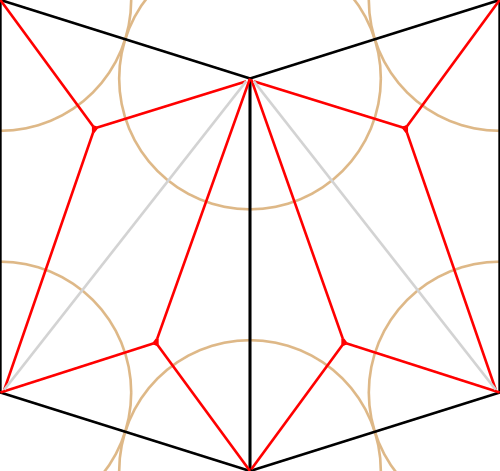

In [23]:
#from sympy import *
#from sympy.plotting import plot
import networkx as nx
import numpy as np
import drawSvg as draw
import time
from itertools import count
from shapely.geometry import Polygon, Point, MultiPoint, LineString
from shapely.geometry.polygon import orient
from shapely.ops import split

circle_color = "#DEB887"
crease_color = "red"
guide_color = "lightgrey"
polygon_color = "black"
precision = 1
scale = 100
line_thickness = 10
viewport = 500
step = 1
epsilon = 0.1
def max_val (points,x=0, y=0):
    for point in points: 
        if point.x > x: x = point.x
        if point.y > y: y = point.y
    return float(x),float(y)
def draw_poly(p,d, col):
    path = draw.Path(stroke=col, stroke_width=line_thickness/viewport*scale, fill='none')
    path.M(p[0][0], p[0][1]) #point is a tuple (x,y)
    [path.L(v[0],v[1]) for v in p]
    d.append(path)
def point_from_id(index, ids): return next((point for point, i in ids.items() if i == index), None)
def shrink_polygon(polygon,sweep_length,ids,d,active,creases,guides):
    # shrink the polygon
    shrunk_poly = polygon.buffer(sweep_length*-1) 
    
    # look for contraction events
    if shrunk_poly.is_empty:
        for p1 in polygon.exterior.coords:        # connect all remaining creases to one another
            for p2 in polygon.exterior.coords:
                if p1 > p2:
                    if (Point(p1).distance(Point(p2))>2*sweep_length):
                        creases.append(LineString([p1,p2]))
        return                                    # stop recursive calling of shrink_polygon
    
    # look for split events
    if len(polygon.exterior.coords) > 4:          # ignore triangles as no split event can happen here
        a = np.where(active == 1)                 # find the active paths
        for i in range(len(a[0])):
            cut_path = LineString([point_from_id(a[0][i],ids),point_from_id(a[1][i],ids)])
            if Point(cut_path.coords[0]).distance(Point(cut_path.coords[1]))-d[ids[cut_path.coords[0]]][ids[cut_path.coords[1]]] < epsilon:
                guides.append(cut_path)
                split_1,split_2 = split(polygon, cut_path)
                shrink_polygon(split_1,sweep_length,ids.copy(),d,get_active_paths(split_1,ids, d),creases,guides)
                shrink_polygon(split_2,sweep_length,ids.copy(),d,get_active_paths(split_2,ids, d),creases,guides)
                return
            
    # generate creases        
    for i,p in enumerate(polygon.exterior.coords):
        extend_creases(creases,LineString([p,shrunk_poly.exterior.coords[i]]))
        if i>0: ids[shrunk_poly.exterior.coords[i]] = ids.pop(p)
    
    # recursively call the shrinking with the new polygon
    shrink_polygon(shrunk_poly,sweep_length,ids,d,active,creases,guides)
    
def extend_creases(creases,extension):
    for crease in creases:
        if extension.coords[0] in crease.coords or extension.coords[1] in crease.coords:
            l1 = (LineString([crease.coords[0],extension.coords[1]]))
            l2 = (LineString([crease.coords[0],extension.coords[0]]))
            l3 = (LineString([crease.coords[1],extension.coords[0]]))
            l4 = (LineString([crease.coords[1],extension.coords[1]]))
            creases.remove(crease)
            if l1.length >= max(l2.length, l3.length, l4.length) : creases.append(l1)
            elif l2.length >= max(l1.length, l3.length, l4.length) : creases.append(l2) 
            elif l3.length >= max(l2.length, l1.length, l4.length) : creases.append(l3)  
            elif l4.length >= max(l2.length, l3.length, l1.length) : creases.append(l4) 
            return
    creases.append(extension)
               
def render(points,circles,creases,guides,polys):
    w,h = max_val(points)
    d = draw.Drawing (w,h)
    for c in circles:  draw_poly(c.exterior.coords,d,circle_color)
    for p in lang_polys: draw_poly(p.exterior.coords,d,polygon_color)
    #TODO: union colinear creases
    for crease in creases: draw_poly(crease.coords,d,crease_color)
    for g in guides: draw_poly(g.coords,d,guide_color)
    d.setRenderSize(viewport,viewport*h/w)
    d.saveSvg("export.svg")
    return d

#def set_markers(T,polygon,ids):
    # for each edge in polygon find the id, traverse the tree polygon.exterior = linearRing
def tree_method(polygons,sweep_length,ids,d,creases,guides):
    for polygon in polygons:
        active_paths = get_active_paths(polygon,ids, d)
        # set "markers" on the 0 edges that require more than 2 nodes to traverse
        shrink_polygon(polygon,sweep_length,ids.copy(),d,active_paths,creases,guides)
        
def get_active_paths(polygon,ids,d):
    paths = np.zeros((len(ids),len(ids)))
    for p1 in polygon.exterior.coords:
            for p2 in polygon.exterior.coords:
                if ids[p1] > ids[p2]:
                    if  abs(Point(p1).distance(Point(p2))-d[ids[p1]][ids[p2]]) > epsilon:
                        paths[ids[p1]][ids[p2]] = 1

    return paths

#TODO: do the actual NLopt for circle packing
raw_points = Point(0,0.6), Point(0,3.6), Point(1.908,0),Point(1.908,3), Point(3.816,0.6), Point(3.816,3.600)
points = [Point(p.x*scale,p.y*scale) for p in raw_points]
point_ids = {}
set_id = count()
T = nx.Graph()
for p in points:
    point_ids[p.coords[0]] = next(set_id)
    T.add_node(point_ids[p.coords[0]], pos=points)
inner_node1 = next(set_id)
inner_node2 = next(set_id)    

T.add_node(inner_node1)
T.add_node(inner_node2)
T.add_edge(0,inner_node2,weight=1*scale)
T.add_edge(1,inner_node1,weight=1*scale)
T.add_edge(2,inner_node2,weight=1*scale)
T.add_edge(3,inner_node1,weight=1*scale)
T.add_edge(4,inner_node2,weight=1*scale)
T.add_edge(5,inner_node1,weight=1*scale)
T.add_edge(inner_node1,inner_node2,weight=1*scale)
d = {x[0]:x[1] for x in nx.all_pairs_dijkstra_path_length(T)}   
print(nx.all_pairs_dijkstra_path_length(T))


# TODO: make the size of circles the length in the tree
circles = [point.buffer(1*scale) for point in points]


#TODO figure out again where the polygons come from
lang_polys = [Polygon(MultiPoint(points[:4]).convex_hull),Polygon(MultiPoint(points[2:]).convex_hull)] #convex hull guarantees the right orientation of the points

creases, guides = [],[]
tree_method(lang_polys,step,point_ids.copy(),d,creases,guides)
render(points,circles,creases,guides,lang_polys)


